In [1]:
import rinokeras
from rinokeras.models.transformer import Transformer
import tensorflow.contrib.eager as tfe
from Dataset import Dataset
import tensorflow as tf
import numpy as np
#import fastText
import tqdm
import os, time

In [2]:
tf.enable_eager_execution()

In [3]:
dataset = Dataset("nl_summaries_small_eval.0.4.json")
dataset.load()

input_length = 400; output_length = 100; dim = 304
%load_ext autoreload
%autoreload 2
offset = 3 # Hack for now, due to beginning of word vocab

In [4]:
# OPTIONAL: No need to install unless you want to get Rouge / Meteor scores
# Installation: https://github.com/Maluuba/nlg-eval
# from nlgeval import NLGEval

# n = NLGEval()

In [4]:
n_vocab = len(dataset.vocab)
print(n_vocab)
model = Transformer(discrete=True, n_layers=3, n_symbols_in=n_vocab, d_model=dim, n_symbols_out=n_vocab, embedding_initializer=np.zeros((n_vocab, dim)), share_source_target_embedding=True)

# Very hacky: do a forward run to force the model to be built, before loading the weights.
encode, decode, mask, decode_mask = dataset.build_batch(['input', 'output', 'input_mask', 'output_mask'], size=64, cut='evaluation', types=[tf.int32,tf.int32,tf.bool,tf.bool])
decoded_logits = model(encode, decode, encoder_mask=mask, decoder_mask=decode_mask)

32003
Reached 2


In [5]:
model.load_weights("summarize_adam_ckpt.h5")

In [6]:
# Testing loss in eager mode

# encode, decode, mask, decode_mask = dataset.build_batch(['input', 'output', 'input_mask', 'output_mask'], size=64, cut='training', types=[tf.int32,tf.int32,tf.bool,tf.bool])
# decoded_logits = model(encode, decode, encoder_mask=mask, decoder_mask=decode_mask)
# train_loss = tf.losses.sparse_softmax_cross_entropy(decode, decoded_logits, tf.cast(decode_mask, tf.float32))
# # train_loss = tf.contrib.seq2seq.sequence_loss(decoded_logits, decode, tf.cast(decode_mask, tf.float32))
# print("Train loss:",float(train_loss))

encode, decode, mask, decode_mask = dataset.build_batch(['input', 'output', 'input_mask', 'output_mask'], size=64, cut='evaluation', types=[tf.int32,tf.int32,tf.bool,tf.bool])
decoded_logits = model(encode, decode, encoder_mask=mask, decoder_mask=decode_mask)
test_loss = tf.losses.sparse_softmax_cross_entropy(decode, decoded_logits, tf.cast(decode_mask, tf.float32))

# test_loss = tf.contrib.seq2seq.sequence_loss(decoded_logits, decode, tf.cast(decode_mask, tf.float32))
print("Eval loss:",float(test_loss))

Reached 2
Eval loss: 2.6138360500335693


In [7]:
for i in tqdm.tqdm_notebook(range(1)):
    encode, decode, encoder_mask, decode_mask = dataset.build_batch(['input', 'output', 'input_mask', 'output_mask'], size=1, cut='evaluation', types=[tf.int32,tf.int32,tf.bool,tf.bool])

    fstyle_decode_logits = model.test_decode(encode, output_length, encoder_mask=encoder_mask) # 
    #tstyle_decode_logits = model(encode, decode, encoder_mask=encoder_mask, decoder_mask=decode_mask) # Train style decoded output, cheating
    #test_loss = tf.contrib.seq2seq.sequence_loss(tstyle_decode_logits, decode, tf.cast(decode_mask, tf.float32))
    
    #tstyle_words = np.argmax(tstyle_decode_logits, axis=2) + offset
    fstyle_words = fstyle_decode_logits.numpy() + offset

    decode += offset #Hack
    encode += offset #Hack
    
    article_content = dataset.evaluate_sentence(encode.numpy())[0]
    real_summary = dataset.evaluate_sentence(np.array(decode))[0]
    
    fstyle_summ = dataset.evaluate_sentence(fstyle_words)[0]
    #tstyle_summ = dataset.evaluate_sentence(tstyle_words)[0]
    
    print ("This sentence loss:",test_loss.numpy())
    print("News article:")
    print(article_content)
    print("---------------")
    print("Gold summary:",real_summary)
    print("---------------")
    print("Fast decode summary:",fstyle_summ)
    print("---------------")
    #print("(Fake decoded summary: "+tstyle_summ+")")
    #print( "==================")

This sentence loss: 2.613836
News article:
When Adam Rodin took his 93-year-old father Sam to hospital for breathing difficulties, he was confident that he was in the right hands. Not only had Mr Rodin had always had good health, the family were confident they could navigate the NHS: Adam is a a consultant obstetrician and gynaecologist at Barnet Hospital, his wife Bridget is a retired nurse, and his twin brother Andrew is a consultant physician. But Mr Rodin died five weeks after being admitted with breathing difficulties to a large teaching hospital in London. This weekend his son came forward - despite working in the NHS - to accuse those who were supposed to care for his father of a string of failings. Mr Rodin jnr said that his father was not fed properly, losing a third of his body weight in hospital, that he was shunted between 15 wards in six weeks, that there was a lack of communication among staff, and finally, that a nurse berated his family for giving the 93 year-old water 

In [8]:
input_self = np.load("input_self_attention.npy").squeeze()
output_self = np.load("output_self_attention.npy").squeeze()
cross = np.load("cross_attention.npy").squeeze()

#print(input_self.shape, output_self.shape, cross.shape)

INPUT SELF ATTENTION


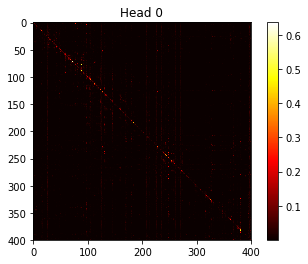

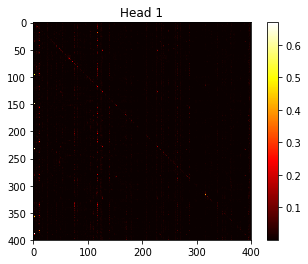

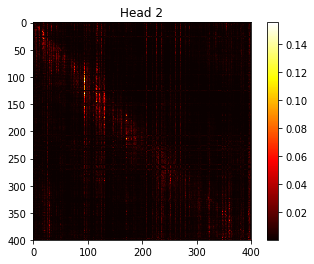

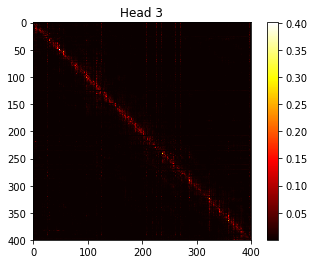

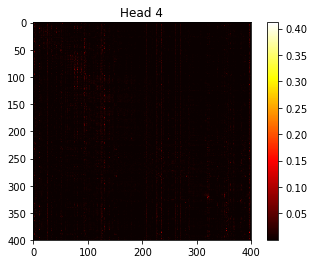

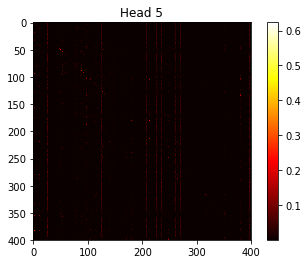

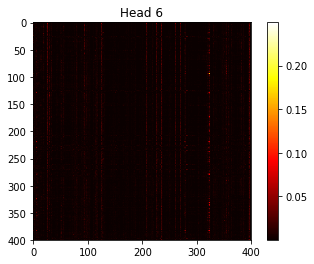

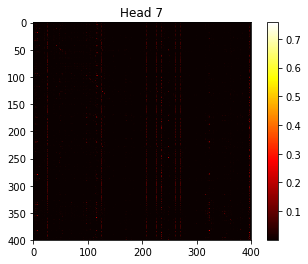

In [14]:
import matplotlib.pyplot as plt
#fix, axes = plt.subplot(4,2)
print('INPUT SELF ATTENTION')
for i in range(8):
    plt.title("Head " + str(i))
    plt.imshow(input_self[i], cmap = "hot")
    plt.colorbar()
    plt.show()
  

OUTPUT SELF ATTENTION


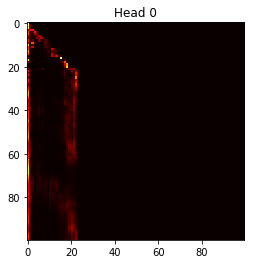

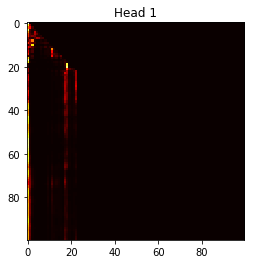

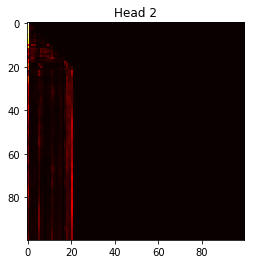

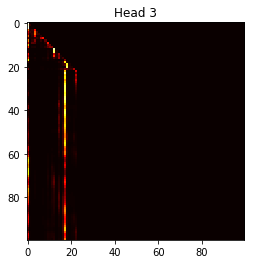

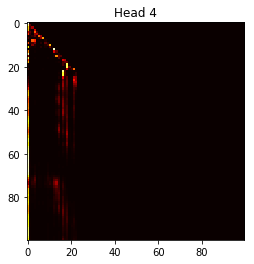

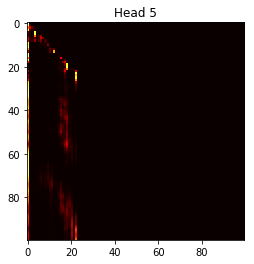

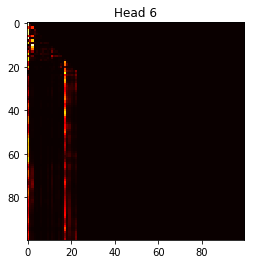

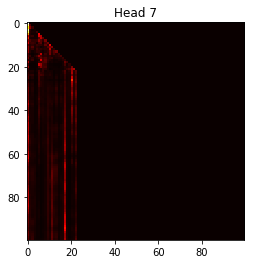

In [11]:
print('OUTPUT SELF ATTENTION')
for i in range(8):
    plt.title("Head " + str(i))
    plt.imshow(output_self[i], cmap = "hot")
    plt.show()
   

CROSS ATTENTION


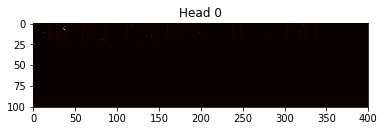

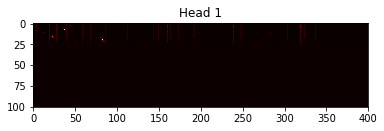

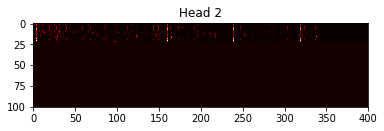

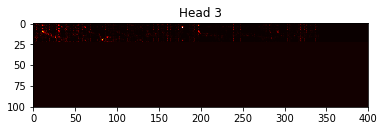

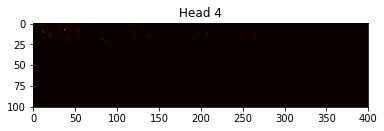

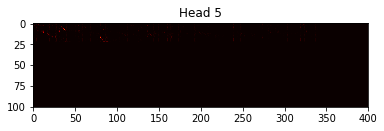

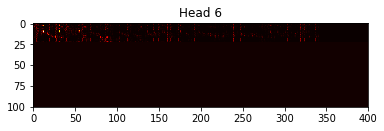

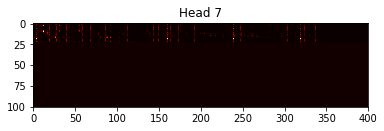

In [12]:
print('CROSS ATTENTION')
for i in range(8):
    plt.title("Head " + str(i))
    plt.imshow(cross[i], cmap = "hot")
    plt.show()

In [13]:
test = np.load("weights.npy")
print(test.shape == (1, 8, 100, 400))
test = np.squeeze(test)
import matplotlib.pyplot as plt
#fix, axes = plt.subplot(4,2)
# for i in range(8):
#     plt.imshow(test[i], cmap = "hot")
#     plt.show()

True


### Evaluation based on 6000 evaluation samples
- 'Bleu_1': 0.25076293160378826
- 'Bleu_2': 0.16896252164926842
- 'Bleu_3': 0.13368250541763457
- 'Bleu_4': 0.1138641951058073
- 'METEOR': 0.13881139746244472
- 'ROUGE_L': 0.21399892905364282
- 'CIDEr': 0.725381810610675